In [19]:
import pandas as pd
import matplotlib.pyplot as plt

results_df = pd.read_csv('../data/driver-results-monza.csv',)

results_df



,number,driver,constructor,position,grid,year
0,3,michael_schumacher,ferrari,1,1,2000
1,1,hakkinen,mclaren,2,3,2000
2,9,ralf_schumacher,williams,3,7,2000
3,19,verstappen,arrows,4,11,2000
4,12,wurz,benetton,5,13,2000
...,...,...,...,...,...,...
521,77,bottas,sauber,16,19,2024
522,27,hulkenberg,haas,17,10,2024
523,24,zhou,sauber,18,20,2024
524,18,stroll,aston_martin,19,17,2024


In [ ]:
grid_res_df = results_df[results_df['position'] == 1]


,number,driver,constructor,position,grid,year
0,3,michael_schumacher,ferrari,1,1,2000
22,6,montoya,williams,1,1,2001
44,2,barrichello,ferrari,1,4,2002
64,1,michael_schumacher,ferrari,1,1,2003
84,2,barrichello,ferrari,1,1,2004
104,10,montoya,mclaren,1,1,2005
124,5,michael_schumacher,ferrari,1,2,2006
146,1,alonso,mclaren,1,1,2007
168,15,vettel,toro_rosso,1,1,2008
188,23,barrichello,brawn,1,5,2009


<positron-console-cell-23>:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


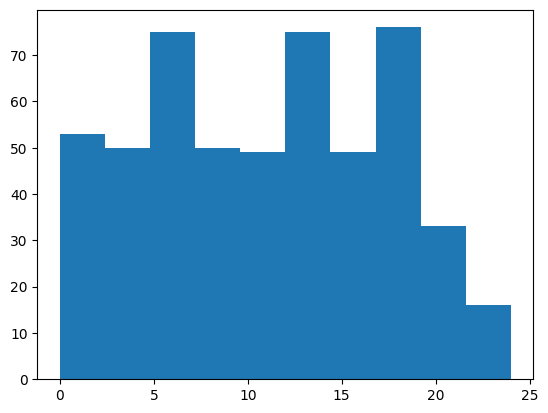

In [ ]:
fig, ax = plt.subplots()

ax.hist(x = grid_res_df["grid"])

fig.show()